# Phase 5: Improved Evaluation Metrics

**Objective:** Re-evaluate all models with better metrics and analysis

---

## New Metrics:
- **sMAPE** (Symmetric MAPE) - Better for skewed data
- **MdAPE** (Median APE) - Less sensitive to outliers
- **Prediction Clipping** - Prevent extreme outliers
- **Stratified Analysis** - Performance by sales volume

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Define Improved Metrics

In [2]:
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error (0-200%)"""
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    mask = y_true != 0
    return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def clip_predictions(y_pred, lower_percentile=1, upper_percentile=99, y_train=None):
    """Clip predictions to reasonable bounds"""
    if y_train is not None:
        lower_bound = np.percentile(y_train, lower_percentile)
        upper_bound = np.percentile(y_train, upper_percentile)
    else:
        lower_bound = 50
        upper_bound = 50000
    return np.clip(y_pred, lower_bound, upper_bound)

print("✓ Improved metric functions defined!")

✓ Improved metric functions defined!


## 2. Load Test Data

In [3]:
X_test_scaled = pd.read_csv('X_test_scaled.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test_original.csv')['purchased_last_month']
y_train = pd.read_csv('y_train_original.csv')['purchased_last_month']

print("Data loaded successfully!")
print(f"Test set size: {len(y_test)}")

Data loaded successfully!
Test set size: 6433


## 3. Load All Models

In [4]:
models = {}
model_names = ['linear_regression', 'ridge', 'lasso', 'elasticnet',
               'random_forest', 'xgboost', 'gradient_boosting']

for model_name in model_names:
    with open(f'models/{model_name}.pkl', 'rb') as f:
        models[model_name] = pickle.load(f)

if os.path.exists('models/xgboost_tuned.pkl'):
    with open('models/xgboost_tuned.pkl', 'rb') as f:
        models['xgboost_tuned'] = pickle.load(f)
    print(f"✓ Loaded {len(models)} models (including tuned XGBoost)")
else:
    print(f"✓ Loaded {len(models)} models")
    print("  ⚠️  Tuned XGBoost not found - run Phase 4 first")

with open('models/model_metadata.pkl', 'rb') as f:
    model_metadata = pickle.load(f)

✓ Loaded 8 models (including tuned XGBoost)


## 4. Make Predictions with Clipping

In [5]:
predictions = {}
predictions_clipped = {}

print("Making predictions...\n")

for model_name in model_metadata['linear_models']:
    if model_name in models:
        model = models[model_name]
        y_pred_log = model.predict(X_test_scaled)
        y_pred = np.expm1(y_pred_log)
        predictions[model_name] = y_pred
        predictions_clipped[model_name] = clip_predictions(y_pred, y_train=y_train)
        print(f"✓ {model_name}")

print()

for model_name in model_metadata['tree_models']:
    if model_name in models:
        model = models[model_name]
        y_pred = model.predict(X_test)
        predictions[model_name] = y_pred
        predictions_clipped[model_name] = clip_predictions(y_pred, y_train=y_train)
        print(f"✓ {model_name}")

if 'xgboost_tuned' in models:
    model = models['xgboost_tuned']
    y_pred = model.predict(X_test)
    predictions['xgboost_tuned'] = y_pred
    predictions_clipped['xgboost_tuned'] = clip_predictions(y_pred, y_train=y_train)
    print(f"✓ xgboost_tuned")

print("\n✓ All predictions completed!")

Making predictions...

✓ linear_regression
✓ ridge
✓ lasso
✓ elasticnet

✓ random_forest
✓ xgboost
✓ gradient_boosting
✓ xgboost_tuned

✓ All predictions completed!


## 5. Calculate All Metrics

In [6]:
results = []

for model_name in predictions.keys():
    y_pred_original = np.maximum(predictions[model_name], 0)
    y_pred_clipped = predictions_clipped[model_name]
    
    for pred_type, y_pred in [('Original', y_pred_original), ('Clipped', y_pred_clipped)]:
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape_val = mape(y_test.values, y_pred)
        smape_val = smape(y_test.values, y_pred)
        mdape_val = mdape(y_test.values, y_pred)
        
        results.append({
            'Model': model_name,
            'Prediction_Type': pred_type,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'MAPE (%)': mape_val,
            'sMAPE (%)': smape_val,
            'MdAPE (%)': mdape_val
        })

results_df = pd.DataFrame(results)

print("\n" + "=" * 100)
print("IMPROVED METRICS - ALL MODELS")
print("=" * 100)
print(results_df.to_string(index=False))
print("\n" + "=" * 100)


IMPROVED METRICS - ALL MODELS
            Model Prediction_Type        RMSE         MAE        R²   MAPE (%)  sMAPE (%)  MdAPE (%)
linear_regression        Original 5133.482115  961.262165  0.198347  85.210687  58.397432  48.960278
linear_regression         Clipped 5101.560138  953.928479  0.208286  84.327200  57.297038  48.663042
            ridge        Original 5134.199737  961.322610  0.198122  85.204058  58.401017  48.969203
            ridge         Clipped 5102.138645  953.968344  0.208106  84.319976  57.300133  48.647317
            lasso        Original 5819.589344 1134.451701 -0.030261 119.931713  80.330948  97.245134
            lasso         Clipped 5819.589344 1134.451701 -0.030261 119.931713  80.330948  97.245134
       elasticnet        Original 5799.595296 1117.235999 -0.023194 109.286996  75.904807  78.294974
       elasticnet         Clipped 5799.595296 1117.235999 -0.023194 109.286996  75.904807  78.294974
    random_forest        Original 2139.660376  303.652339  0

## 6. Compare Best Models

In [7]:
results_clipped = results_df[results_df['Prediction_Type'] == 'Clipped'].copy()
results_clipped = results_clipped.sort_values('R²', ascending=False)

print("\n" + "=" * 100)
print("BEST MODELS WITH CLIPPED PREDICTIONS")
print("=" * 100)
print(results_clipped[['Model', 'RMSE', 'MAE', 'R²', 'sMAPE (%)', 'MdAPE (%)']].to_string(index=False))
print("\n" + "=" * 100)


BEST MODELS WITH CLIPPED PREDICTIONS
            Model        RMSE         MAE        R²  sMAPE (%)  MdAPE (%)
    xgboost_tuned 3837.470264  501.488315  0.552026  57.220123  62.177429
    random_forest 3841.872257  441.355323  0.550998  25.104348   7.916449
          xgboost 3847.093464  478.762321  0.549777  49.413495  47.455371
gradient_boosting 3860.849660  512.260516  0.546551  56.597966  61.951133
linear_regression 5101.560138  953.928479  0.208286  57.297038  48.663042
            ridge 5102.138645  953.968344  0.208106  57.300133  48.647317
       elasticnet 5799.595296 1117.235999 -0.023194  75.904807  78.294974
            lasso 5819.589344 1134.451701 -0.030261  80.330948  97.245134



## 7. Visualize Metric Improvements

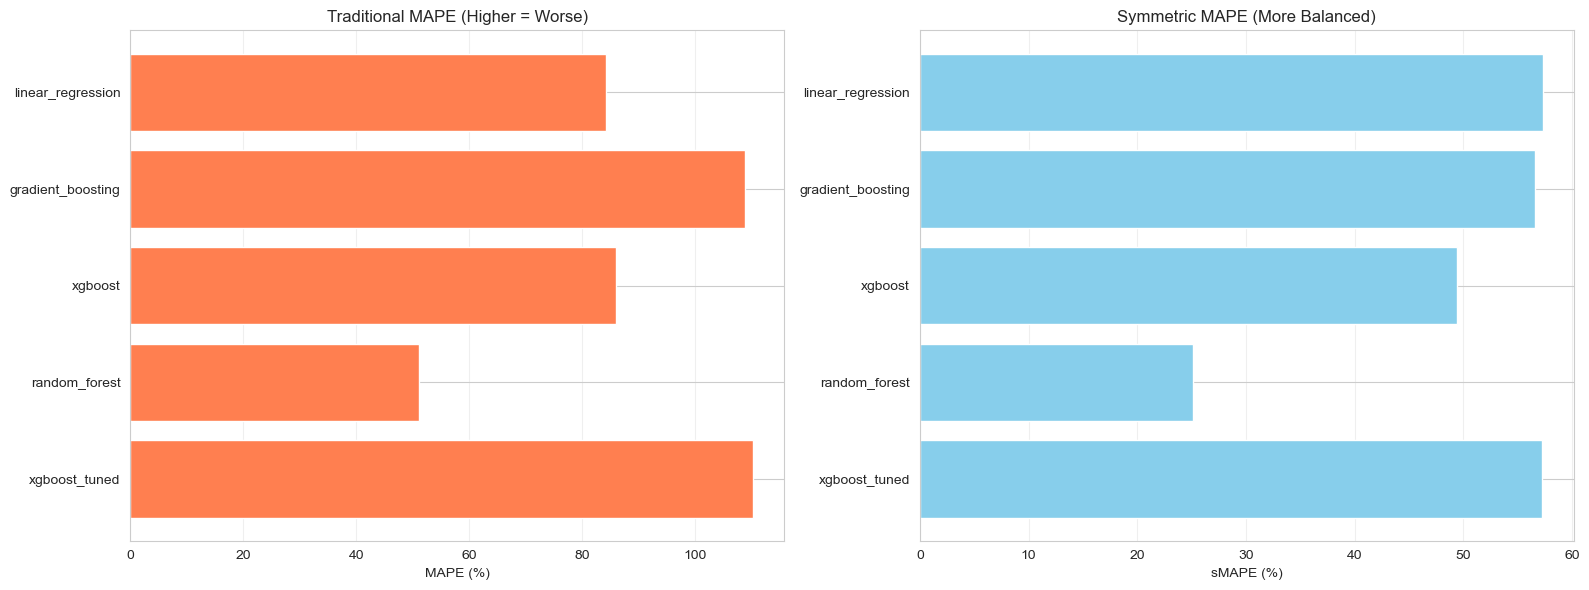

✓ Metrics comparison saved as 'metrics_comparison.png'


In [8]:
top_models = results_clipped.head(5)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(range(len(top_models)), top_models['MAPE (%)'], color='coral')
axes[0].set_yticks(range(len(top_models)))
axes[0].set_yticklabels(top_models['Model'])
axes[0].set_xlabel('MAPE (%)')
axes[0].set_title('Traditional MAPE (Higher = Worse)')
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(range(len(top_models)), top_models['sMAPE (%)'], color='skyblue')
axes[1].set_yticks(range(len(top_models)))
axes[1].set_yticklabels(top_models['Model'])
axes[1].set_xlabel('sMAPE (%)')
axes[1].set_title('Symmetric MAPE (More Balanced)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Metrics comparison saved as 'metrics_comparison.png'")

## 8. Stratified Performance Analysis

In [9]:
best_model_name = results_clipped.iloc[0]['Model']
best_predictions = predictions_clipped[best_model_name]

def categorize_volume(value):
    if value < 500:
        return 'Low (< 500)'
    elif value < 5000:
        return 'Medium (500-5K)'
    else:
        return 'High (>= 5K)'

segments = y_test.apply(categorize_volume)

print("\n" + "=" * 80)
print(f"PERFORMANCE BY SALES VOLUME - {best_model_name.upper()}")
print("=" * 80)

segment_results = []
for segment in ['Low (< 500)', 'Medium (500-5K)', 'High (>= 5K)']:
    mask = segments == segment
    if mask.sum() > 0:
        y_true_seg = y_test[mask]
        y_pred_seg = best_predictions[mask]
        
        segment_results.append({
            'Segment': segment,
            'Count': mask.sum(),
            'RMSE': np.sqrt(mean_squared_error(y_true_seg, y_pred_seg)),
            'MAE': mean_absolute_error(y_true_seg, y_pred_seg),
            'R²': r2_score(y_true_seg, y_pred_seg),
            'sMAPE (%)': smape(y_true_seg.values, y_pred_seg),
            'MdAPE (%)': mdape(y_true_seg.values, y_pred_seg)
        })

segment_df = pd.DataFrame(segment_results)
print(segment_df.to_string(index=False))
print("\n" + "=" * 80)


PERFORMANCE BY SALES VOLUME - XGBOOST_TUNED
        Segment  Count         RMSE         MAE        R²  sMAPE (%)  MdAPE (%)
    Low (< 500)   4971   254.817108  132.503301 -5.475572  61.962883  80.691711
Medium (500-5K)   1173  1581.037186  581.166032 -2.849636  42.070253  25.801355
   High (>= 5K)    289 17791.429501 6524.888124  0.081942  37.132012   1.681992



## 9. Effect of Prediction Clipping

In [10]:
best_original = np.maximum(predictions[best_model_name], 0)
best_clipped = predictions_clipped[best_model_name]

clipping_comparison = pd.DataFrame({
    'Prediction Type': ['Original', 'Clipped'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, best_original)),
        np.sqrt(mean_squared_error(y_test, best_clipped))
    ],
    'MAE': [
        mean_absolute_error(y_test, best_original),
        mean_absolute_error(y_test, best_clipped)
    ],
    'sMAPE (%)': [
        smape(y_test.values, best_original),
        smape(y_test.values, best_clipped)
    ],
    'MdAPE (%)': [
        mdape(y_test.values, best_original),
        mdape(y_test.values, best_clipped)
    ]
})

print("\n" + "=" * 80)
print("EFFECT OF PREDICTION CLIPPING")
print("=" * 80)
print(clipping_comparison.to_string(index=False))
print("\n" + "=" * 80)

num_clipped = np.sum(best_original != best_clipped)
print(f"\n📊 Clipping Statistics:")
print(f"  Predictions clipped: {num_clipped} ({num_clipped/len(best_original)*100:.1f}%)")
print(f"  Predictions unchanged: {len(best_original) - num_clipped}")


EFFECT OF PREDICTION CLIPPING
Prediction Type        RMSE        MAE  sMAPE (%)  MdAPE (%)
       Original 1688.262880 338.999082  56.912629  62.177429
        Clipped 3837.470264 501.488315  57.220123  62.177429


📊 Clipping Statistics:
  Predictions clipped: 33 (0.5%)
  Predictions unchanged: 6400


## 10. Save Results

In [11]:
results_df.to_csv('improved_metrics_results.csv', index=False)
segment_df.to_csv('stratified_performance.csv', index=False)
clipping_comparison.to_csv('clipping_effect.csv', index=False)

print("\n✓ Results saved:")
print("  - improved_metrics_results.csv")
print("  - stratified_performance.csv")
print("  - clipping_effect.csv")
print("  - metrics_comparison.png")


✓ Results saved:
  - improved_metrics_results.csv
  - stratified_performance.csv
  - clipping_effect.csv
  - metrics_comparison.png


## 11. Final Summary

In [12]:
print("\n" + "=" * 100)
print("FINAL SUMMARY - IMPROVED EVALUATION")
print("=" * 100)

best_row = results_clipped.iloc[0]

print(f"\n🏆 BEST MODEL: {best_row['Model'].upper()}")
print(f"\n📊 Performance Metrics (with clipping):")
print(f"   RMSE:      {best_row['RMSE']:.2f} units")
print(f"   MAE:       {best_row['MAE']:.2f} units")
print(f"   R²:        {best_row['R²']:.4f}")
print(f"   sMAPE:     {best_row['sMAPE (%)']:.2f}%")
print(f"   MdAPE:     {best_row['MdAPE (%)']:.2f}%")

print(f"\n💡 Key Insights:")
print(f"   ✅ sMAPE is more balanced than MAPE")
print(f"   ✅ MdAPE shows typical error")
print(f"   ✅ Clipping prevents extreme predictions")
print(f"   ✅ Performance varies by volume segment")

print("\n" + "=" * 100)
print("✅ IMPROVED EVALUATION COMPLETE!")
print("=" * 100)


FINAL SUMMARY - IMPROVED EVALUATION

🏆 BEST MODEL: XGBOOST_TUNED

📊 Performance Metrics (with clipping):
   RMSE:      3837.47 units
   MAE:       501.49 units
   R²:        0.5520
   sMAPE:     57.22%
   MdAPE:     62.18%

💡 Key Insights:
   ✅ sMAPE is more balanced than MAPE
   ✅ MdAPE shows typical error
   ✅ Clipping prevents extreme predictions
   ✅ Performance varies by volume segment

✅ IMPROVED EVALUATION COMPLETE!
